In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.integrate import quad
from skopt import gp_minimize


We consider the evaluation of the following integral
$$
\bar{f_p} = \int f(x)p(x)dx 
$$
where $p(x)$ is a probability (density), and $f(x)$ is the function we wish to integrate


- The Classical Monte Carlo Method make the approximation:

$$
\bar{f_p}=\frac{1}{T}\sum_{t=1}^{T} f(x_t)
$$

where $x_t$ are random (not necessarily independent) draws from $p(x)$.

It is also possible to draw samples from some importance sampling distribution
$q(x)$ to obtain the estimate:

$$ \bar{f_p}=\frac{1}{T}\sum_{t=1}^{T} f(x_t)\frac{p(x_t)}{q(x_t)} $$


- In the  Bayesian Monte Carlo, we proceed by putting a prior on $f$ through Gaussian Processes (GP) in this case.
Under a GP prior the joint distribution of any (finite) number of function values (indexed
by the inputs, $x$ is Gaussian: 

$$ \mathbf{f}= {(f(x_1),f(x_2), \cdot \cdot \cdot ,f(x_n) )}^T =  \mathcal{N}(0,\,K)\ $$

where the mean is taken as zero and the covariance matrix is given by the covariance
function (.....1). 
$$ K_{pq}= \mathcal{Cov}( f(x_p), f(x_q))= w_0 \exp{(-\frac{1}{2} \sum_{d=1}^{D}\frac{(x_p^{(d)}-x_q^{(d)})^2}{w_d^2})}$$

 where $w$ parameters are hyperparameters to optimize.


 Concretely, the Bayesian Monte Carlo method starts with a prior over the function, $p(f)$ and makes
inferences about $f$ from a set of samples $ \mathcal{D} = \{(x_i, f(x_i)) |i = 1 . . . n\} $ 


 (1)- The standard approximation results for a GP process is:
$f_D(x) = k(x, \mathbf{x})K^{-1}\mathbf{f}$ and $ CovD(f(x), f(x^{\prime}) = k(x, x^{\prime})−k(x, \mathbf{x})K^{-1}k(\mathbf{x}, x^{\prime}) $

where  $\mathbf{x}$ and  $\mathbf{f}$ are the observed inputs and function values respectively. General case is lead to expressions difficult to evaluate.

(2)- [Special case] If the density $p(x)$ and the covariance function are both Gaussian, i.e : $p(x)=\mathcal{N}(b,\,B)$ and the Gaussian kernel on the data point is $\mathcal{N}(a_i=x_i,\, A=diag(w_1^2, w_2^2, \cdot, \cdot, \cdot, w_D^2))$ , we obtain: 


$$\mathrm{E}_{f|\mathcal{D}}[\bar{f_p}] = z^TK^{-1}\mathbf{f} , \quad z=w_0|A^{-1}B + I|^{-0.5}\exp[-0.5(a-b)^T(A+B)^{-1}(a-b)]$$
$$\mathrm{V}_{f|\mathcal{D}}[\bar{f_p}] =  w_0| 2A^{-1}B + I|^{-0.5}  - z^TK^{-1}z$$















## Implement SMC

In [3]:
class SMC:
    def __init__(self,f,p,lwb, upb,T):
        self.f=f
        self.p=p
        self.T=T
        self.clear()
    def clear(self):
        self.x=np.zeros(self.T)
    
    def evaluate(self):
        pass

In [4]:
def smc(f,x,T):
    return 1/T*np.sum(f(x))

smc  0.6478 True integrand:  0.9699531057009148


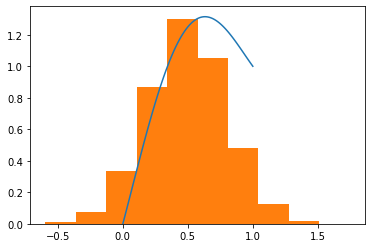

In [5]:
def f(x):
    if x>=0 and x<=1:
        return np.sin(np.pi*x)+x**2
    return 0
f=np.vectorize(f)

x=norm(loc=0.5,scale=0.3).rvs(size=10000)
print("smc ", smc(f,x,10000), "True integrand: ", quad(f,0,1)[0])

#plot
plt.plot(np.linspace(0,1,100),f(np.linspace(0,1,100)))
plt.hist(x, density=True)
plt.show()

We can clearly notice that the choice of the gaussian distribution parameters is very important to get an aproximation close to the real integral. Indeed the sample has to be expanded on all the segment we wish to integrate and most importantly well distributed along values where the evaluation of f outputs small and big values. If we sample more  where f is  evaluated  small (resp. evaluated big), we get a lower (resp. upper opproximation). So the optimization strategie of bayesian monte carlo makes sense.

- One dimensional case

(2)- [Special case] If the density $p(x)$ and the covariance function are both Gaussian, i.e : $p(x)=\mathcal{N}(b,\,B)$ and the Gaussian kernel on the data point is $\mathcal{N}(a_i=x_i,\, A=diag(w_1^2, w_2^2, \cdot, \cdot, \cdot, w_D^2))$ , we obtain: 


$$\mathrm{E}_{f|\mathcal{D}}[\bar{f_p}] = z^TK^{-1}\mathbf{f} , \quad z=w_0|A^{-1}B + I|^{-0.5}\exp[-0.5(a-b)^T(A+B)^{-1}(a-b)]$$
$$\mathrm{V}_{f|\mathcal{D}}[\bar{f_p}] =  w_0| 2A^{-1}B + I|^{-0.5}  - z^TK^{-1}z$$

In [62]:
b=np.array([0])
B=np.array([[1]])
w=np.array([.1,.5])
a=np.array([2])
d=b.shape[0]
A=np.diag(w[1:])
p=multivariate_normal(mean=b,cov=B)

z=w[0]*np.linalg.inv(np.sqrt(abs(np.linalg.inv(A)@B + np.eye(d))))*np.exp(-.5*(a-b).T@np.linalg.inv(A+B)@(a-b))

x=p.rvs(10).reshape(10,1)
fb=f(x)
K=covariance_function(x,w=np.array([0.1,.5]))

E=z*np.linalg.inv(K)@fb 
V=w[0]*np.linalg.inv(np.sqrt(abs(2*np.linalg.inv(A)@B + np.eye(d)))) -z*np.linalg.inv(K)*z
E.shape, V.shape
E.mean()
# multivariate_normal(mean=E.flatten(),cov=V).rvs()

array([[1.]])

In [ ]:
def g_p(X, y, k,noise_level, x, w):

    # input: X (inputs), y (targets), k (covariance function), σ2n (noise level),x∗ (test input)
    n,d=X.shape
    K=k(x,w[1:])
    # 2: L := cholesky(K + σ2nI)
    L=cholesky(K+sigma*np.eyes(n))
    # α := L.T\(L\y)
    alpha=L.T/(L/y)
    # 4: bar f∗ := k∗.Tα              # predictive mean eq
    mean_f= k(x,X).T@alpha
    # v := L\k∗
    v=L/k(x,X)
    # 6: V[f∗] := k(x∗, x∗) − v.Tv             # predictive variance 
    V[mean_f]=k(x,x)-v.T@v

    # log p(y|X) := −1/2y.Tα −sum log Lii −n/2log(2π) 
    return  −.5*y.T@alpha −np.sum(np.log(np.diag(L))) -.5*n*np.log(2*np.pi)    # 8: return: bar f∗ (mean), V[f∗] (variance), log p(y|X) (log marginal likelihood)

In [86]:
def k(X,x,w):
    K=[]
    n,d=x.shape
    w=np.array(w)
    for i in range(n):
        K.append(w[0]*np.exp(-0.5*np.sum((x[i,:]-X)**2/w[1:]**2, axis=1)))
    return np.array(K)

class bmc:
    def __init__(self, X, y,k,noise_level,x,p):
        self.n,self.d=X.shape
        self.k=k
        self.X,self.y=X,y
        self.x=x
        self.p=p
        
    def log_marginal(self,w):
        self.K=self.k(self.X,self.X,w)
        self.L=np.linalg.cholesky(self.K+noise_level*np.eye(self.n))
        self.alpha=np.linalg.inv(self.L.T)@np.linalg.inv(self.L)@self.y
        log_p=-.5*self.y.T@self.alpha - np.sum(np.log(np.diag(self.L))) -.5*self.n*np.log(2*np.pi)
        return log_p[0][0]

    def optimize(self):
#         w_0=(1/self).d*np.ones(self.d+1)
        dimensions=[(0.001,1.) for i in range(self.d+1)]
        res=gp_minimize(self.log_marginal,                  # the function to minimize
                  dimensions,                     # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234) 
        self.w=res.x
        print(res.x)
         
    def compute(self):
        self.optimize()
        b,B=self.p.mean,self.p.cov
        A=np.diag(self.w[1:])
        
        # compute z 

        z=self.w[0]*np.sqrt(np.linalg.det(np.linalg.inv(A)@B + np.eye(self.d)))*np.exp(-.5*np.diag((self.X-b)@np.linalg.inv(A+B)@(self.X-b).T))

        print(z.shape)
        k_=self.k(self.X,self.X, self.w)
        self.mean_f= k_@self.alpha
        self.v=np.linalg.inv(self.L)@self.k(self.X,self.X,self.w).T
        self.var_f=np.diag(self.k(self.X,self.X,self.w).T)-self.v.T@self.v
    
#         z= z.reshape((1,self.n))
        print(z.shape, self.K.shape,self.y.shape)
        E=z.T@np.linalg.inv(self.K)@self.y
        
        V=self.w[0]*np.sqrt(np.linalg.det(2*np.linalg.inv(A)@B + np.eye(self.d)))-z.T@np.linalg.inv(self.K)@z

        return self.mean_f,self.var_f, E,V


C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\kalae\

[1.0, 0.001]
(10,)
(10,) (10, 10) (10, 1)


C:\Users\kalae\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


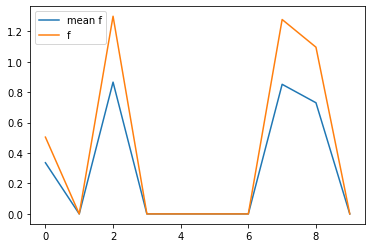

In [87]:
b=np.array([0.5])
B=np.array([[1]])
w=np.array([.1,.5])
a=np.array([2])
d=b.shape[0]
A=np.diag(w[1:])
p=multivariate_normal(mean=b,cov=B)

X=p.rvs(10).reshape(10,1)
y=f(X)
x=np.array([[1]])
noise_level=.5

bm=bmc(X,y,k,noise_level, x,p)
bm.log_marginal(w=w)
mean_f,var_f, I, var_I=bm.compute()

plt.plot(mean_f, label="mean f")
plt.plot(y, label="f")
plt.legend()

In [93]:
E.shape,V.shape

((10, 1), (10, 10))